# Fitting epistasis models to experiments with narrow bottlenecks
This example does the following three major things:

**Complete**

## Setup for analysis

Import Python modules / packages:

In [1]:
import collections
import itertools
import random
import tempfile
import time
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Set parameters that define the simulated data.
We simulate the experiment with a very tight bottleneck, a moderately tight bottleneck, and a loose bottleneck.
For the very tight and moderately tight bottlenecks, we expect the bottlenecks to be the major source of noise:

In [2]:
seed = 1  # random number seed
genelength = 50  # gene length in codons
libs = ['lib_1']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 100  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib,
        'mid_bottle': variants_per_lib * 3,
        'loose_bottle': variants_per_lib * 100,
        }

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate wildtype gene sequence:

In [7]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 50 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Plot the number of amino-acid mutations per variant:

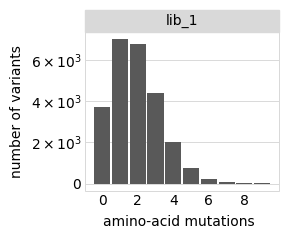

In [9]:
p = variants.plotNumMutsHistogram('aa', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of codon mutations per variant:

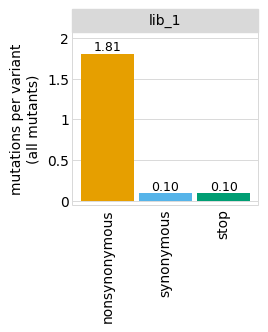

In [10]:
p = variants.plotNumCodonMutsByType(variant_type='all', samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Numerical data in the plot above:

In [11]:
variants.numCodonMutsByType('all', samples=None).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,45156,25000,1.806
1,lib_1,barcoded variants,synonymous,2414,25000,0.097
2,lib_1,barcoded variants,stop,2416,25000,0.097


Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times, making separate plots for single mutants and all mutants:

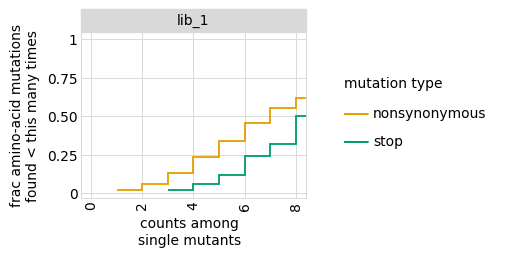

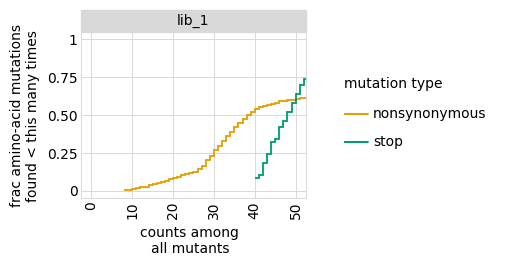

In [12]:
for variant_type in ['single', 'all']:
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type='aa',
                                      samples=None)
    _ = p.draw()

## Simulate counts for samples
Now we simulate the counts of each variant after selection.

First, we define a “phenotype” function using a
[SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator),
which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in
two steps: an underlying latent phenotype that mutations affect additively, and
then an observed phenotype that is a non-linear
function of the latent phenotype.
The variants are then simulated according to their observed enrichments, which are the exponentials of the observed phenotypes:

In [13]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                                            geneseq,
                                            seed=seed)

Plot the simulated relationship of the latent phenotype with the observed enrichment and phenotype, with a dashed
vertical line indicating the wildtype latent phenotype:

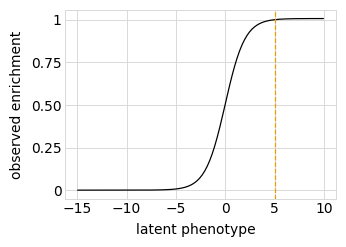

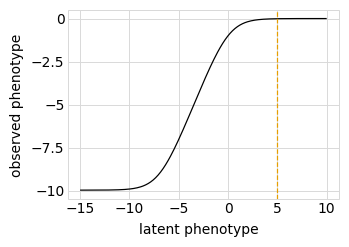

In [14]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot the latent phenotype, observed phenotype, and observed enrichment of all single amino-acid mutants, with a
dashed vertical line indicating the wildtype:

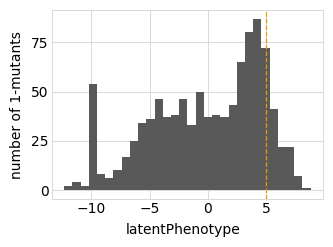

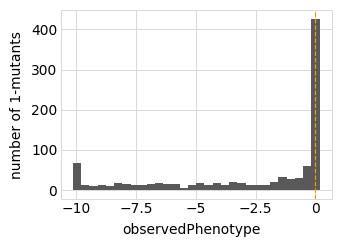

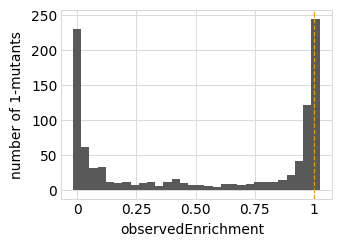

In [15]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts)
to simulate counts of variants when selection on each variant is proportional to
its observed enrichment.
We simulate using the several different bottleneck sizes defined above:

In [16]:
counts = dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={'total_count': variants_per_lib *avgdepth_per_variant,
                    'uniformity': lib_uniformity},
        pre_sample_name='pre-selection',
        post_samples={name: {'noise': noise,
                             'total_count': variants_per_lib * avgdepth_per_variant,
                             'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
        seed=seed,
        )

Now add the simulated counts for each library /
sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [17]:
variants.add_sample_counts_df(counts)

Confirm that we have added the expected number of counts per library /
sample:

In [18]:
variants.n_variants_df()

,library,sample,count
0,lib_1,pre-selection,2500000
1,lib_1,loose_bottle,2500000
2,lib_1,mid_bottle,2500000
3,lib_1,tight_bottle,2500000


Plot the number of counts for each variant in each sample. 
The horizontal
dashed line shows the total number of variants. 
The plot shows that all
variants are well-sampled in the pre-selection libraries, but that post-
selection some variants are sampled more or less.
This is expected since
selection will decrease and increase the frequency of variants:

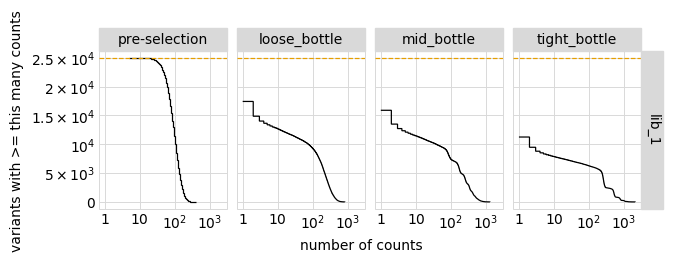

In [19]:
p = variants.plotCumulVariantCounts(orientation='v')
_ = p.draw()

Distribution of the number of amino-acid mutations per variant in each sample.
As expected, mutations go down after selection:

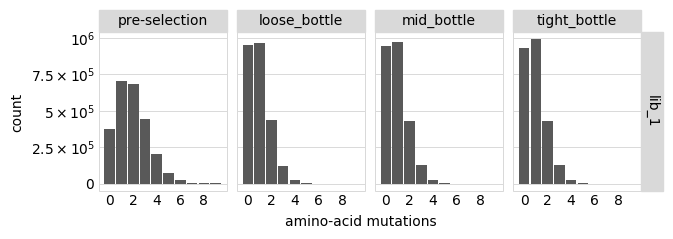

In [20]:
p = variants.plotNumMutsHistogram(mut_type='aa', orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Average number of mutations per variant:

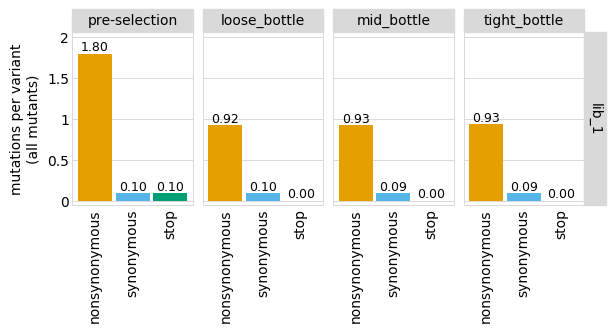

In [21]:
p = variants.plotNumCodonMutsByType(variant_type='all', orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Here are the numerical data plotted above (just for the individual libraries and all mutations):

In [22]:
# NBVAL_IGNORE_OUTPUT

variants.numCodonMutsByType(variant_type='all', libraries=libs).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,4499341,2500000,1.800
1,lib_1,pre-selection,synonymous,238214,2500000,0.095
2,lib_1,pre-selection,stop,241920,2500000,0.097
3,lib_1,loose_bottle,nonsynonymous,2311298,2500000,0.925
4,lib_1,loose_bottle,synonymous,238008,2500000,0.095
5,lib_1,loose_bottle,stop,1755,2500000,0.001
6,lib_1,mid_bottle,nonsynonymous,2319456,2500000,0.928
7,lib_1,mid_bottle,synonymous,231668,2500000,0.093
8,lib_1,mid_bottle,stop,1726,2500000,0.001
9,lib_1,tight_bottle,nonsynonymous,2331864,2500000,0.933


## Functional scores for variants
Use
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
to calculates a functional score for each variant based on its change in
frequency from pre- to post-selection:

In [23]:
func_scores = variants.func_scores('pre-selection',
                                   libraries=libs)

Also calculate functional scores at the level of amino-acid variants:

In [24]:
aa_func_scores = variants.func_scores('pre-selection',
                                      by='aa_substitutions',
                                      syn_as_wt=True,
                                      libraries=libs)

Classify variants
by the “types” of mutations they
have using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants):

In [25]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(func_scores)

Plot the distributions of scores, coloring by the variant class.
As expected, there is more noise with a tighter bottleneck:

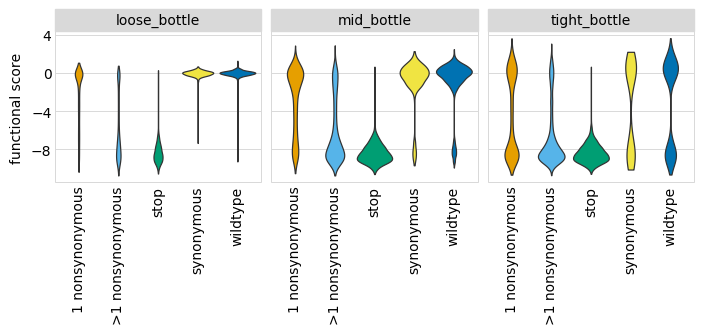

In [26]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_wrap('~ post_sample') +
    theme(figure_size=(2.75 * len(bottlenecks), 
                       2 * len(libs)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Fit global epistasis models


In [27]:
# NBVAL_IGNORE_OUTPUT

models = {}  # store models, keyed by `(modeltype, sample, lib)`

for (sample, lib), scores in func_scores.groupby(['post_sample',
                                                  'library']):
   
    bmap = dms_variants.binarymap.BinaryMap(scores)
    
    for modeltype, EpistasisModel in [
            ('global epistasis', dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood),
            ('no epistasis', dms_variants.globalepistasis.NoEpistasisGaussianLikelihood),
            ]:
        print(f"Fitting {modeltype} model to {sample}, {lib}...", end=' ')
    
        start = time.time()
        model = EpistasisModel(bmap)
        model.fit(ftol=1e-7)  # do NOT change ftol in normal use, this is just for test
        print(f"fitting took {time.time() - start:.1f} sec.")
        models[(modeltype, sample, lib)] = model

Fitting global epistasis model to loose_bottle, lib_1... fitting took 33.2 sec.
Fitting no epistasis model to loose_bottle, lib_1... fitting took 0.3 sec.
Fitting global epistasis model to mid_bottle, lib_1... fitting took 10.0 sec.
Fitting no epistasis model to mid_bottle, lib_1... fitting took 0.2 sec.
Fitting global epistasis model to tight_bottle, lib_1... fitting took 8.8 sec.
Fitting no epistasis model to tight_bottle, lib_1... fitting took 0.1 sec.


Now we want to see which model fits the data better.
To do this, we get the log likelihood of each model along with the number of model parameters and use it to calculate the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion).
Models with lower AIC are better, and below we see that the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model always fits the data much better:

In [28]:
# NBVAL_IGNORE_OUTPUT

logliks_df = (
    pd.DataFrame.from_records(
            [(modeltype, sample, lib, model.nparams, model.loglik) for
             (modeltype, sample, lib), model in models.items()],
            columns=['model', 'sample', 'library',
                     'n_parameters', 'log_likelihood']
            )
    .assign(AIC=lambda x: 2 * x['n_parameters'] - 2 * x['log_likelihood'])
    .set_index(['sample', 'library'])
    )

logliks_df.round(1)

model  n_parameters  log_likelihood       AIC
sample       library                                                          
loose_bottle lib_1    global epistasis          1008        -24387.0   50790.0
             lib_1        no epistasis          1002        -47620.5   97245.0
mid_bottle   lib_1    global epistasis          1008        -44548.9   91113.9
             lib_1        no epistasis          1002        -55606.8  113217.7
tight_bottle lib_1    global epistasis          1008        -63291.7  128599.4
             lib_1        no epistasis          1002        -65496.6  132997.1

In [29]:
# check to confirm the global epistasis model is better in all cases
assert (logliks_df
        .reset_index()
        .pivot_table(index=['sample', 'library'],
                     values='AIC',
                     columns='model'
                     )
        .assign(global_better=lambda x: x['global epistasis'] < x['no epistasis'])
        ['global_better']
        .all()
        )

Because the [MonotonicSplineEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.MonotonicSplineEpistasis) global epistasis model fits so much better than the additive [NoEpistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.NoEpistasis) model, below we are just going to analyze the results from the global epistasis model.

First, we will examine how the model looks on all the actual variants used to fit the model.
We use [AbstractEpistasis.phenotypes_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.phenotypes_df) to get a data frame of all the variants used to fit each global epistasis model along with their functional scores and the latent and observed phenotypes predicted by each model.
We also compute the measured and model-predicted enrichments for each variant (recall that the functional score / observed phenotype is the $\log_2$ of the enrichment as described [here](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)):

In [30]:
variants_df = pd.concat(
        [model.phenotypes_df
         .assign(sample=sample,
                 library=lib,
                 predicted_enrichment=lambda x: model.enrichments(
                                                 x['observed_phenotype']),
                 measured_enrichment=lambda x: 2**x['func_score'],
                 )
         for (modeltype, sample, lib), model in models.items()
         if modeltype == 'global epistasis'],
        ignore_index=True, sort=False)

Below we plot the relationships among the latent phenotype from the model, the observed phenotype from the model, and the measured functional score for all variants used to fit the model:

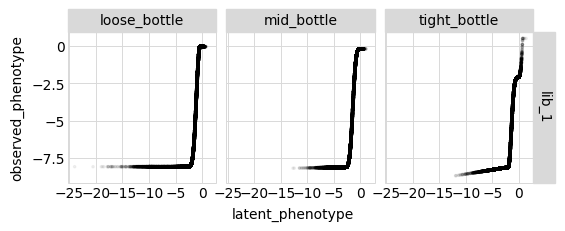

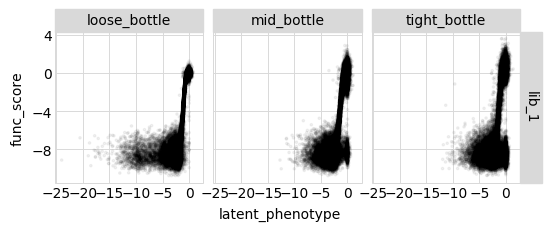

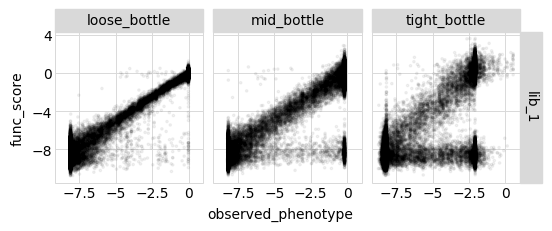

In [31]:
for x, y in itertools.combinations(['latent_phenotype',
                                    'observed_phenotype',
                                    'func_score'],
                                   2):
    p = (
        ggplot(variants_df, aes(x, y)) +
        geom_point(alpha=0.05, size=0.5) +
        facet_grid('library ~ sample', scales='free_y') +
        theme(figure_size=(2 * variants_df['sample'].nunique(),
                           2 * variants_df['library'].nunique()),
              )
        )
    _ = p.draw()

## Model vs measurements vs truth for all variants

Because we simulated the variants, we can also use the [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator) used in these simulations to get the **true** phenotype of each variant.
(Obviously in real non-simulated experiments the true phenotypes are unknown.)
We get the true latent phenotype, the true observed phenotype (which corresponds to the functional score), and true enrichment:

In [32]:
variants_df = (
    variants_df
    .assign(
        true_latent_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.latentPhenotype),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        true_observed_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedPhenotype),
        )
    )

Now we calculate the correlations between the true enrichment (from the simulation) and the measured enrichment or model-predicted enrichment, calculating the correlations across all variants.
We do this using enrichment rather than observed phenotype as we expect the observed phenotypes to be very noisy at the "low end" (since experiments lose the sensitivity to distinguish among bad and really-bad variants):

In [33]:
# NBVAL_IGNORE_OUTPUT

enrichments_corr = (
    variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

,enrichment_type,measurement,model prediction
sample,library,,
loose_bottle,lib_1,0.97,1.00
mid_bottle,lib_1,0.74,1.00
tight_bottle,lib_1,0.55,0.89


In [34]:
# this cell is just for testing purposes, and reprints some of the above
# data frame for `nbval` testing.
print(enrichments_corr.to_csv(float_format='%.1f'))

sample,library,measurement,model prediction
loose_bottle,lib_1,1.0,1.0
mid_bottle,lib_1,0.7,1.0
tight_bottle,lib_1,0.5,0.9



And below are the correlation plots corresponding to the correlation coefficients tabulated above:

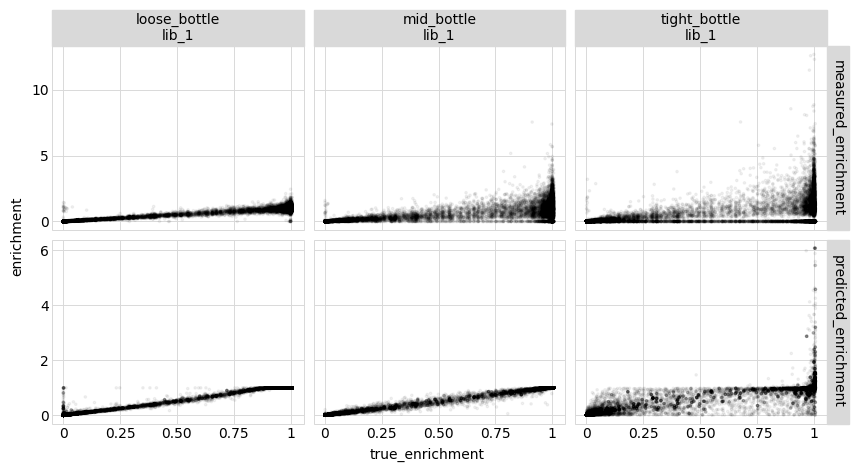

In [35]:
p = (ggplot(variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

These results show that the model predictions are closer to the true values than the actual measurements, which is great!
This could be because modeling the data helps extract more signal from multiple mutants--but it could also be for the trivial reason that the model effectively averages over multiple variants with the same mutations, which could be more accurate than the individual measurements.
Therefore, in the next section we look at this issue...

## Model vs measurements vs truth for amino-acid variants
We want to see if the model still outperforms the experiments if look at the level of **amino-acid** variants (meaning we pool the counts for all variants with the same amino-acid substitutions together before calculating the functional scores).
Recall that above we already got such functional scores into the variable `aa_func_scores`:

First we get a data frame of simulated functional scores calculated at the level of amino-acid variants (pooling all barcoded variants with the same amino-acid mutations):

In [36]:
aa_variants_df = (
    aa_func_scores
    .rename(columns={'post_sample': 'sample'})
    [['sample', 'library', 'aa_substitutions',
      'n_aa_substitutions', 'func_score']]
    .assign(measured_enrichment=lambda x: 2**x['func_score'])
    )

Now we add the model-predicted latent phenotype, observed phenotype, and enrichment for each amino-acid variant using the [AbstractEpistasis.add_phenotypes_to_df](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.AbstractEpistasis.add_phenotypes_to_df) method:

In [37]:
df_list = []
for (sample, lib), df in aa_variants_df.groupby(['sample', 'library']):
    model = models[('global epistasis', sample, lib)]
    df_list.append(model.add_phenotypes_to_df(df)
                   .assign(predicted_enrichment=lambda x: 
                              model.enrichments(x['observed_phenotype'])
                           )
                   )
aa_variants_df = pd.concat(df_list, ignore_index=True, sort=False)

Now we add the "true" values from the simulator:

In [38]:
aa_variants_df = (
    aa_variants_df
    .assign(
        true_latent_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.latentPhenotype),
        true_enrichment=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedEnrichment),
        true_observed_phenotype=lambda x: x['aa_substitutions'].map(
                phenosimulator.observedPhenotype),
        )
    )

Now we calculate and plot the correlations between the true enrichments from the simulations and the measured values and the ones predicted by the model:

In [39]:
# NBVAL_IGNORE_OUTPUT

enrichments_corr = (
    aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

,enrichment_type,measurement,model prediction
sample,library,,
loose_bottle,lib_1,0.98,0.99
mid_bottle,lib_1,0.81,0.99
tight_bottle,lib_1,0.65,0.81


In [40]:
# this cell is just for testing purposes, and reprints some of the above
# data frame for `nbval` testing.
print(enrichments_corr.to_csv(float_format='%.1f'))

sample,library,measurement,model prediction
loose_bottle,lib_1,1.0,1.0
mid_bottle,lib_1,0.8,1.0
tight_bottle,lib_1,0.7,0.8



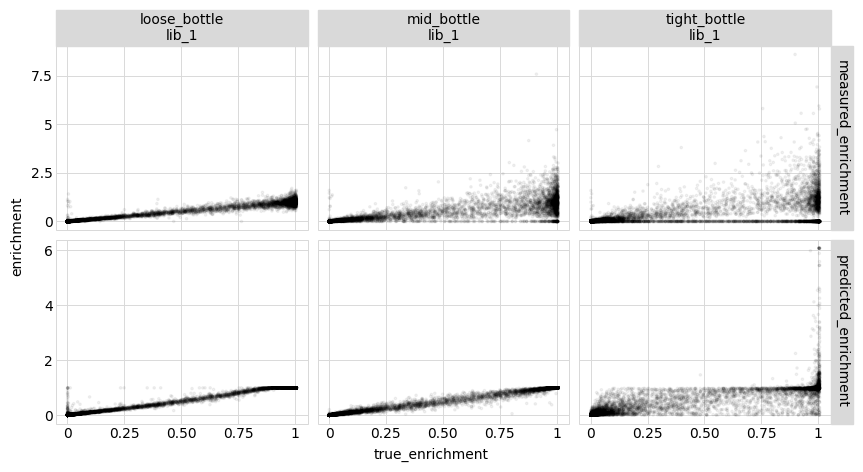

In [41]:
p = (ggplot(aa_variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

The results above show that the model still outperforms the direct measurements even when the measurements are aggregated at the level of amino-acid variants.

## Model vs measurements vs truth for single mutants
Now we repeat the above analysis for just **single** amino-acid mutants.

First, get the single amino-acid mutant variants:

In [42]:
single_aa_variants_df = (
    aa_variants_df
    .query('n_aa_substitutions == 1')
    .reset_index(drop=True)
    )

In [43]:
# This cell is just for nbval testing
assert (single_aa_variants_df.columns.tolist() ==
        ['sample', 'library', 'aa_substitutions', 'n_aa_substitutions',
         'func_score', 'measured_enrichment', 'latent_phenotype',
         'observed_phenotype', 'predicted_enrichment', 'true_latent_phenotype',
         'true_enrichment', 'true_observed_phenotype'])

Now tabulate and plot how the model predictions and measurements compare to the true values:

In [44]:
# NBVAL_IGNORE_OUTPUT

enrichments_corr = (
    single_aa_variants_df
    .rename(columns={'predicted_enrichment': 'model prediction',
                     'measured_enrichment': 'measurement'})
    .melt(id_vars=['sample', 'library', 'true_enrichment'],
          value_vars=['model prediction', 'measurement'],
          var_name='enrichment_type',
          value_name='enrichment',
          )
    .groupby(['sample', 'library', 'enrichment_type'])
    .apply(lambda x: x['enrichment'].corr(x['true_enrichment']))
    .rename('correlation')
    .to_frame()
    .pivot_table(index=['sample', 'library'],
                 values='correlation',
                 columns='enrichment_type')
    )

enrichments_corr.round(2)

,enrichment_type,measurement,model prediction
sample,library,,
loose_bottle,lib_1,0.99,0.99
mid_bottle,lib_1,0.91,1.00
tight_bottle,lib_1,0.80,0.80


In [45]:
# this cell is just for testing purposes, and reprints some of the above
# data frame for `nbval` testing.
print(enrichments_corr.to_csv(float_format='%.1f'))

sample,library,measurement,model prediction
loose_bottle,lib_1,1.0,1.0
mid_bottle,lib_1,0.9,1.0
tight_bottle,lib_1,0.8,0.8



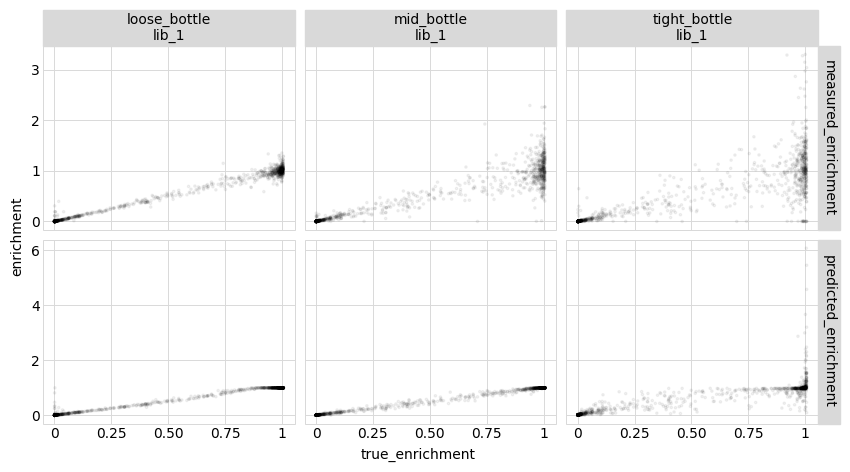

In [46]:
p = (ggplot(single_aa_variants_df
            .melt(id_vars=['sample', 'library', 'true_enrichment'],
                  value_vars=['predicted_enrichment', 'measured_enrichment'],
                  var_name='enrichment_type',
                  value_name='enrichment',
                  ),
            aes('true_enrichment', 'enrichment')) +
     geom_point(alpha=0.05, size=0.5) +
     facet_grid('enrichment_type ~ sample + library',
                scales='free_y') +
     theme(figure_size=(2.5 * (variants_df['sample'].nunique() +
                               variants_df['library'].nunique()),
                        5)
           )
     )

_ = p.draw()

We see that even for single mutants, fitting the global epistasis model leads to more accurate measurements of the effects of mutations.
Presumably this is because these models are able to effectively extract information from the multiple mutants.